<a href="https://colab.research.google.com/github/moexalgo/moexalgo.github.io/blob/main/examples/library-examples/websocket/streams/candles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install moexalgo
#!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from moexalgo.beta import issplus

# Данные для входа
ws_login = 'ваш_логин'
ws_passcode = 'ваш_пароль'

# Доступные интервалы: M1, M10, H1, D1, W1, m1, m3, Q1
interval = 'D1'
ticker = 'SBER'

async def websocket_candles():
    url = 'wss://iss.moex.com/infocx/v3/websocket'
    credentials = issplus.Credentials('passport', ws_login, ws_passcode)
    
    df_snapshot = None
    count = 0
    
    async with issplus.connect(url, credentials) as client:
        # Подписка на свечи (candles) с указанным интервалом
        destination = 'MXSE.candles'
        selector = f'TICKER="MXSE.TQBR.{ticker}" and interval="{interval}"'
        
        subscription = await client.subscribe(destination, selector)
        print(f"Подписка ID: {subscription.id}\n")
        
        async for data in subscription:
            msg_type = data['properties']['type']
            
            # Первое сообщение - исторические данные
            if msg_type == 'snapshot':
                print(f"Снэпшот (snapshot): {len(data['data'])} строк")
                
                df_snapshot = pd.DataFrame(data['data'], columns=data['columns'])
                df_snapshot['close'] = df_snapshot['CLOSE'].apply(lambda x: x[0])
                df_snapshot['begin'] = pd.to_datetime(df_snapshot['FROM'])
                
                # Выведем последние 5 значений
                print(df_snapshot.tail(5))
                print()
                
            # Обновления текущей свечи в реальном времени
            elif msg_type == 'updates':
                count += 1
                print(f"\nОбновление (updates):")
                
                update_row = pd.DataFrame(data['data'], columns=data['columns'])
                update_row['close'] = update_row['CLOSE'].apply(lambda x: x[0])
                update_row['begin'] = pd.to_datetime(update_row['FROM'])
                
                print(update_row)
                print()
                
                if df_snapshot is not None:
                    old_row = df_snapshot[df_snapshot['FROM'] == data['data'][0][0]]

                    if not old_row.empty:
                        old_close = old_row.iloc[0]['close']
                        new_close = update_row.iloc[0]['close']
                        diff = new_close - old_close
                        print(f"Разница: {old_close} → {new_close} ({diff:+.2f})")
                        
                        df_snapshot.loc[df_snapshot['FROM'] == data['data'][0][0], 'close'] = new_close
                
                # Остановка после пяти итераций (для примера)
                if count >= 5:
                    break
    
    return df_snapshot


candles_snapshot = await websocket_candles()


Подписка ID: a00e1fcc-1eb6-4189-b57c-a1f816b2229c

Снэпшот (snapshot): 256 строк
                    FROM                 TILL         OPEN         HIGH  \
251  2026-01-18 00:00:00  2026-01-18 23:59:57  [301.28, 2]  [301.89, 2]   
252  2026-01-19 00:00:00  2026-01-19 23:59:59   [302.0, 2]  [304.73, 2]   
253  2026-01-20 00:00:00  2026-01-20 23:59:58  [303.89, 2]  [304.65, 2]   
254  2026-01-21 00:00:00  2026-01-21 23:59:59   [304.1, 2]  [306.94, 2]   
255  2026-01-22 00:00:00  2026-01-22 09:58:47   [306.6, 2]   [307.0, 2]   

             LOW        CLOSE               VALUE    VOLUME   close      begin  
251   [301.1, 2]  [301.86, 2]   [259434912.83, 2]    860536  301.86 2026-01-18  
252  [300.34, 2]  [303.62, 2]  [7362755348.76, 2]  24288292  303.62 2026-01-19  
253  [302.47, 2]  [304.03, 2]  [5201023168.34, 2]  17136591  304.03 2026-01-20  
254   [303.0, 2]  [306.49, 2]  [8034147581.29, 2]  26303679  306.49 2026-01-21  
255  [305.89, 2]  [305.98, 2]   [445392861.91, 2]   1453473  30

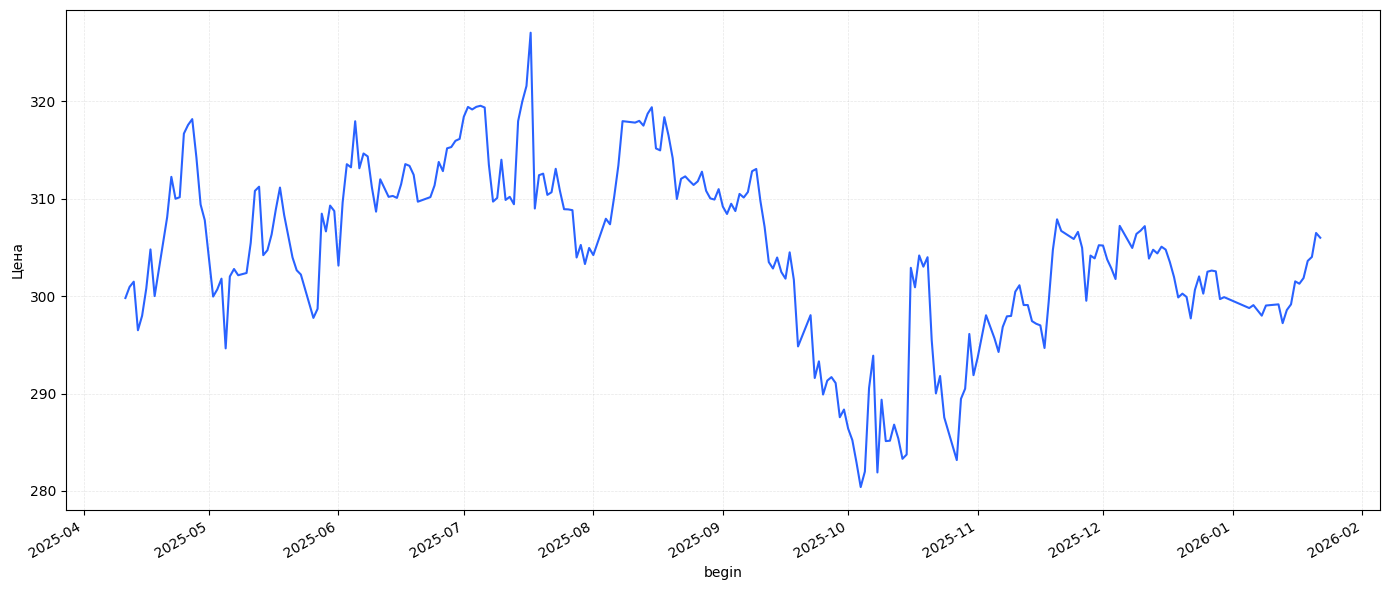

In [5]:
if candles_snapshot is not None:
    ax = candles_snapshot.set_index('begin')['close'].plot(figsize=(14, 6), color='#2962FF', linewidth=1.5)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_ylabel('Цена')
    plt.tight_layout()
    plt.show()
